In [1]:
function phase_ramp2(lines, samples, burst_number, meta, v_mid)
    # fish out constants and parameters
    c = 299792458
    k_psi = meta["azimuth_steering_rate"] * pi/180
    dc_coef = meta["burst_meta"]["data_dc_polynomial"][burst_number, :]
    dc_tau0 = meta["burst_meta"]["data_dc_t0"][burst_number]
    fm_coef = meta["burst_meta"]["azimuth_fm_rate_polynomial"][burst_number, :]
    fm_tau0 = meta["burst_meta"]["azimuth_fm_rate_t0"][burst_number]
    f_c = meta["radar_frequency"]
    lines_per_burst = meta["lines_per_burst"]
    number_of_samples = meta["number_of_samples"]
    Delta_t_s = meta["azimuth_time_interval"]
    Delta_tau_s = 1/meta["range_sampling_rate"]
    tau_0 = meta["slant_range_time"]
    v_s = v_mid
    input = [k_psi, dc_tau0, fm_tau0, f_c, lines_per_burst, number_of_samples, Delta_t_s, Delta_tau_s, tau_0, v_mid]

    # Temporary functions, allows different x=tau inputs
    k_a(x, fm_param, x0) = fm_param[1] .+ fm_param[2].*(x .- x0) .+ fm_param[3].*(x .- x0).^2 # Doppler FM rate, Eqn. 11
    f_etac(x, dc_param, x0) = dc_param[1] .+ dc_param[2].*(x .- x0) .+ dc_param[3].*(x .- x0).^2; # Doppler centroid freq Eqn. 13
    
    tau = tau_0 .+ (samples .- 1) .* Delta_tau_s # Slant range time of ith sample, Eqn. 12

    # Doppler rate equations
    k_s = 2 * v_s/c * f_c * k_psi; # Doppler rate from antenna scanning, Eqn. 4
    alpha = 1 .- k_s ./ k_a(tau, fm_coef, fm_tau0); # conversion factor, Eqn. 3
    k_t = k_s ./ alpha; # Doppler Centroid Rate, Eqn. 2
    
    # Doppler azimuth time equations
    eta_c = - f_etac(tau, dc_coef, dc_tau0) ./ k_a(tau, fm_coef, fm_tau0); # Beam centre crossing time, Eqn. 7
    tau_mid = tau_0 + number_of_samples/2 * Delta_tau_s
    
    eta_ref = eta_c .- (- f_etac(tau_mid, dc_coef, dc_tau0)/k_a(tau_mid, fm_coef, fm_tau0)); # Reference time, Eqn. 6
    line_in_burst = lines .- lines_per_burst*(burst_number-1)
    eta = -lines_per_burst/2*Delta_t_s .+ (line_in_burst .- 1/2 ) .* Delta_t_s

    # Compute the phase ramp added the modulation term
    ramp = pi * k_t .* (eta .- eta_ref).^2 .+ 2 * pi .* f_etac(tau, dc_coef, dc_tau0) .* (eta .- eta_ref); # Eqn. 14
    term1 = sqrt(mean((pi * k_t .* (eta .- eta_ref).^2).^2))
    term2 = sqrt(mean((2 * pi .* f_etac(tau, dc_coef, dc_tau0) .* (eta .- eta_ref)).^2))
    println(minimum(f_etac(tau, dc_coef, dc_tau0)))
    println(maximum(f_etac(tau, dc_coef, dc_tau0)))
    println(minimum(k_t))
    println(maximum(k_t))
    return ramp, term1, term2, dc_coef, fm_coef, samples, lines, input
end

phase_ramp2 (generic function with 1 method)

In [2]:
include("../ToolBox/ToolBox.jl")
include("../path.jl")
using .ToolBox
using .Geometry
using .Load
using .SlcUtil
import .Misc
using DelimitedFiles
using Statistics

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1186
┌ Warning: Module MacroTools with build ID 12047338851717 is missing from the cache.
│ This may mean MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [3]:
# for saving csv's
function save_mean_data(data, name)
    row_means = mean(data, dims=2);
    writedlm(name*"_real.csv", real.(row_means));
    writedlm(name*"_imag.csv", imag.(row_means));
end

save_mean_data (generic function with 1 method)

### Data paths

In [4]:
# Approximate view for 2 burst in master
master_view = [1551:3019, 946:24513]
meta = (Load.slc_meta(master_meta_path), Load.slc_meta(slave_meta_path))
precise_orbit = (Load.precise_orbit(master_pod_path, meta[1]["t_0"]), 
                 Load.precise_orbit(slave_pod_path, meta[2]["t_0"]))

# load DEM
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [5]:
stride=(2,8)

# get some coficents
c = 299792458
range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
lambda =  c/meta[1]["radar_frequency"]

# Get the midburst speed
v_mid = mid_burst_speed(precise_orbit[2], meta[2]);

# look_up_table
mosaic_view = SlcUtil.mosaic_view(meta[1],master_view)
lut = look_up_table(mosaic_view,meta,precise_orbit,dem,stride=(2,8))

# get master line and sample
master_line, master_sample = Misc.flatten(mosaic_view...)

# interpolate slave line and sample
slave_line = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["slave_line"],(length(lut["master_line"]),length(lut["master_sample"])))
,mosaic_view[1], mosaic_view[2])
slave_sample = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
    reshape(lut["slave_sample"],(length(lut["master_line"]),length(lut["master_sample"])))
    ,mosaic_view[1], mosaic_view[2]);

slave_line = reshape(slave_line,:)
slave_sample= reshape(slave_sample,:);

# master bursts
master_start_burst = ceil(Int,(master_view[1].start)/meta[1]["lines_per_burst"])
master_end_burst = ceil(Int,(master_view[1].stop-1)/meta[1]["lines_per_burst"])

# find the slave bursts
slave_start_line = minimum(slave_line)
slave_start_burst = sum([slave_start_line > elem ? 1 : 0 for elem in meta[2]["burst_meta"]["first_line_mosaic"]])

## Get the number of lines in the first selected burst
lines_in_first_burst_master = master_start_burst*meta[1]["lines_per_burst"] - master_view[1].start
lines_in_first_burst_slave = meta[2]["burst_meta"]["first_line_mosaic"][slave_start_burst]+meta[2]["lines_per_burst"] - slave_start_line

## Check if the number of lines are approximately the same
if lines_in_first_burst_slave > lines_in_first_burst_master + 100
    # the number of lines are not the same. The slave burst before should be included
    slave_start_burst = slave_start_burst -1
    lines_in_first_burst_slave = slave_start_burst*meta[2]["lines_per_burst"] - slave_start_line
end

# compute the offset between the burst number in slave and master
delta_burst = slave_start_burst - master_start_burst

## check if it is in slave image
slave_end_burst = master_end_burst + delta_burst

if slave_start_burst == 0
    println("Warning: start line not in slave image")
end

if slave_end_burst > meta[2]["burst_count"]
    println("Warning: end line not in slave image")
end

if minimum(slave_sample) < 1
    println("Warning: start sample not in slave image")
end

if maximum(slave_sample) > meta[2]["samples_per_burst"]
    println("Warning: end sample not in slave image")
end

# Initialize arrays for the results
coreg_slave = Array{Complex{Float64}}(undef,length.(master_view)...)
flat_inferogram = Array{Complex{Float64}}(undef,length.(master_view)...)
reshape_dim = 0
phi = 0
term1 = 0 
term2 = 0
dc_coef = 0 
fm_coef = 0 
samp = 0
lin = 0
input = 0

# load and resample one burst at a time
for n_master in master_start_burst:master_end_burst

    n_slave =  n_master + delta_burst
    print(n_slave)
    if n_slave != 2
        n_slave = 2
    end
    
    start_line_master = meta[1]["lines_per_burst"] * (n_master-1)+1
    end_line_master = meta[1]["lines_per_burst"] * n_master

    ## offset cused by overlap between burts
    over_lap_master = meta[1]["lines_per_burst"]*(n_master-1)+1 - meta[1]["burst_meta"]["first_line_mosaic"][n_master]
    over_lap_slave = meta[2]["lines_per_burst"]*(n_slave-1)+1 - meta[2]["burst_meta"]["first_line_mosaic"][n_slave]

    if n_master == master_start_burst
        start_line_master = master_view[1].start
    end

    if n_master == master_end_burst
        end_line_master = master_view[1].stop
    end

    # finds the lines in the burst
    in_burst = (start_line_master-over_lap_master) .<= master_line .<= (end_line_master-over_lap_master)


    # get lines
    master_line_n = master_line[in_burst] .+ over_lap_master
    slave_line_n = slave_line[in_burst] .+ over_lap_slave

    # get samples
    master_sample_n = master_sample[in_burst]
    slave_sample_n = slave_sample[in_burst]

    # load data
    slave_view_n = round(Int,minimum(slave_line_n)): round(Int,maximum(slave_line_n)),
                round(Int,minimum(slave_sample_n)): round(Int,maximum(slave_sample_n))
    slave_data = Load.slc_data(slave_data_path, slave_view_n);
    
    # deramp
    phi, term1, term2, dc_coef, fm_coef, samp, lin, input = phase_ramp2(Misc.flatten(slave_view_n...)..., n_slave, meta[2], v_mid[n_slave]);
    slave_data = slave_data .* reshape(exp.(-phi .* im), size(slave_data));
    reshape_dim = size(slave_data)
    
    # dimension of resample
    dim = (convert(Int,length(master_line_n)/length(master_view[2])),length(master_view[2]))

    #resample
    slave_data = Misc.resample(slave_view_n,slave_data,slave_line_n,slave_sample_n)
    slave_data = reshape(slave_data, dim);

    # reramp
    phi = SlcUtil.phase_ramp(slave_line_n, slave_sample_n, n_slave, meta[2], v_mid[n_slave])
    slave_data = slave_data .* reshape(exp.(phi .* im), dim);

    # flat_inferogram
    flat = exp.(4*pi.*(master_sample_n.-slave_sample_n).*range_pixel_spacing./lambda.*im)
    flat = reshape(flat,dim);

    # store results
    coreg_slave[(start_line_master:end_line_master) .- (master_view[1].start-1),:] .= slave_data
    flat_inferogram[(start_line_master:end_line_master) .- (master_view[1].start-1),:] .= flat
end

# remove the slave goemtry and return the dict as geo_ref_table
delete!(lut, "slave_sample")
delete!(lut, "slave_line")
geo_ref_table = lut;

23.5002734830791766
24

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


.704940513975473
1489.736486771259
1562.032180155023


In [6]:
# phi, term1, term2, k_t, k_rot, k_a, f_dc, eta_c, eta_ref, dc_coef, fm_coef, input
# input = [k_psi, dc_tau0, fm_tau0, f_c, lines_per_burst, number_of_samples, Delta_t_s, Delta_tau_s, tau_0, v_mid]
k_psi, dc_tau0, fm_tau0, f_c, lines_per_burst, number_of_samples, Delta_t_s, Delta_tau_s, tau_0, v_mid = input;

In [6]:
term1

4885.774131552208

In [7]:
term2

77.4027527235503

In [8]:
tau_test = tau_0 .+ (samp .- 1) .* Delta_tau_s; # Slant range time of ith sample, Eqn. 12
mean(tau_test)*2, tau_0

(0.012440078658605299, 0.00602248003244895)

In [9]:
s_test = reshape(samp,reshape_dim)[1,:];

In [10]:
l_test = reshape(lin, reshape_dim)[:,1];

In [11]:
burst_number = 2

2

In [12]:
using Plots

In [13]:
# Temporary functions, allows different x=tau inputs
k_a(x, fm_param, x0) = fm_param[1] .+ fm_param[2].*(x .- x0) .+ fm_param[3].*(x .- x0).^2 # Doppler FM rate, Eqn. 11
f_etac(x, dc_param, x0) = dc_param[1] .+ dc_param[2].*(x .- x0) .+ dc_param[3].*(x .- x0).^2; # Doppler centroid freq Eqn. 13

tau = tau_0 .+ (s_test .- 1) .* Delta_tau_s # Slant range time of ith sample, Eqn. 12

# Doppler rate equations
k_s = 2 * v_mid/c * f_c * k_psi; # Doppler rate from antenna scanning, Eqn. 4
alpha = 1 .- k_s ./ k_a(tau, fm_coef, fm_tau0); # conversion factor, Eqn. 3
k_t = k_s ./ alpha; # Doppler Centroid Rate, Eqn. 2

# Doppler azimuth time equations
eta_c = - f_etac(tau, dc_coef, dc_tau0) ./ k_a(tau, fm_coef, fm_tau0); # Beam centre crossing time, Eqn. 7
tau_mid = tau_0 + number_of_samples/2 * Delta_tau_s

eta_ref = eta_c .- (- f_etac(tau_mid, dc_coef, dc_tau0)/k_a(tau_mid, fm_coef, fm_tau0)); # Reference time, Eqn. 6
line_in_burst = l_test .- lines_per_burst*(burst_number-1)
eta = -lines_per_burst/2*Delta_t_s .+ (line_in_burst .- 1/2 ) .* Delta_t_s;

In [14]:
minimum(f_etac(tau, dc_coef, dc_tau0)), maximum(f_etac(tau, dc_coef, dc_tau0))

(3.5002734830791766, 24.704940513975473)

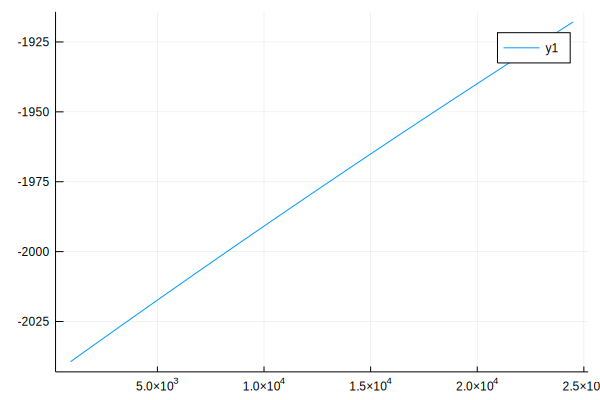

In [44]:
plot(s_test, k_a(tau, fm_coef, fm_tau0))

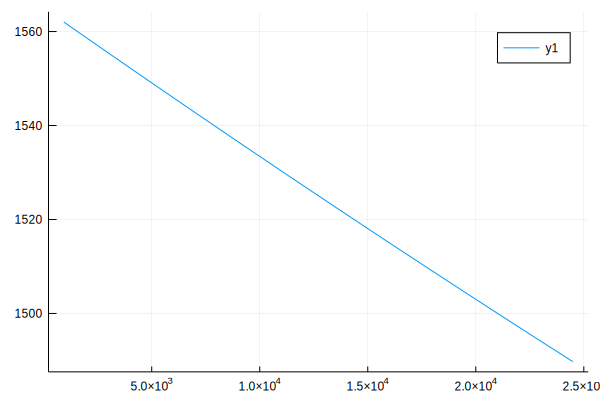

In [46]:
plot(s_test, k_t)

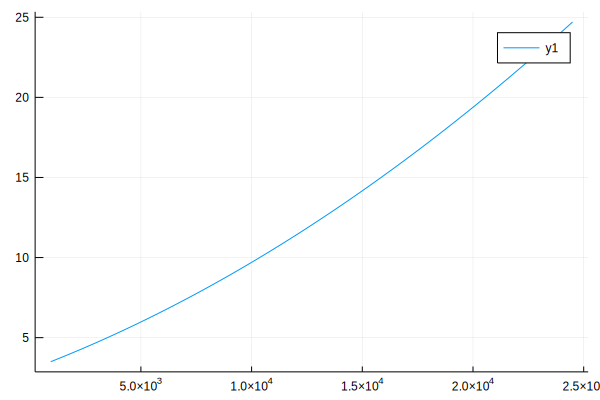

In [49]:
plot(s_test, dc_coef[1] .+ dc_coef[2].*(tau .- dc_tau0) .+ dc_coef[3].*(tau .- dc_tau0).^2)

In [43]:
maximum(tau)

0.0064031608833324755

In [10]:
using Colors

In [11]:
#Gray.(k_t[:, 1:4000])

In [22]:
#test = (k_t .- minimum(k_t)) ./ (maximum(k_t) - minimum(k_t));

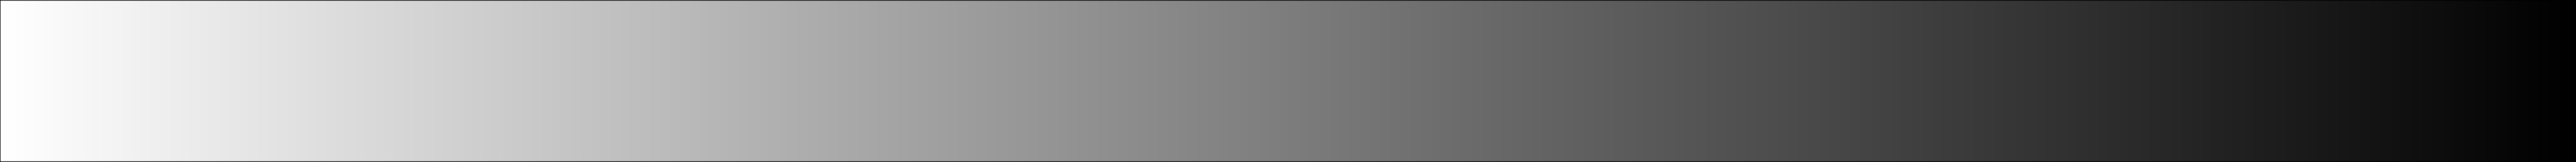

In [19]:
#Gray.(reshape(test, reshape_dim))